# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [3]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 8 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 100
image_width = 100
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int) #create a list of image numbers you want to use for a particular video

In [5]:
from skimage.io import imread
from skimage.transform import resize

def resize_crop_image(image):
    if image.shape[0] > 120 and image.shape[1] > 120:
        image = resize(image, (120, 120))
        
    height = image.shape[0]
    width = image.shape[1]
    height_center = height//2
    width_center = width//2
    image = image[(height_center-60):(height_center+70), (width_center-50):(width_center+70)]
    image = resize(image,(image_height, image_width))
    return image

Let's test the function `resize_crop_image` by writing a test function

In [6]:
from matplotlib import pyplot as plt

def show_resize_crop_image(paths):

    for index, path in enumerate(paths):
        plt.figure(figsize=(20,20))
            
        plt.subplot(5, 2, index*2+1)
        image = resize_crop_image(imread(path))
        plt.imshow(image)
        plt.title('Modified')
        
        plt.subplot(5, 2, index*2+2)
        plt.imshow(imread(path))
        plt.title('Original')
                
    plt.show()

Calling the test function

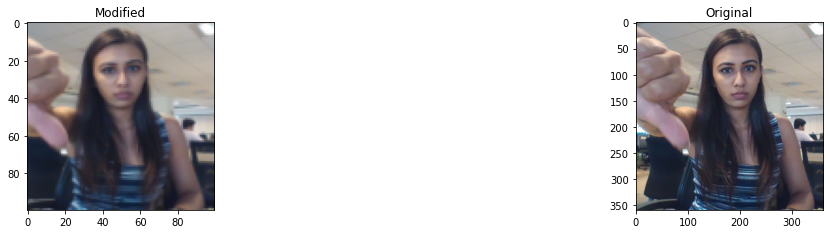

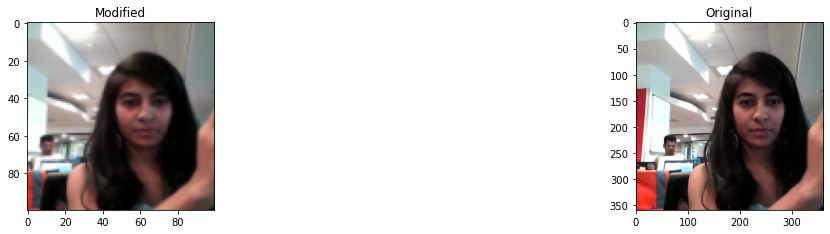

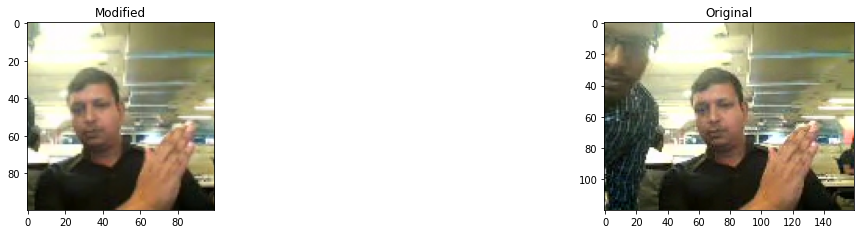

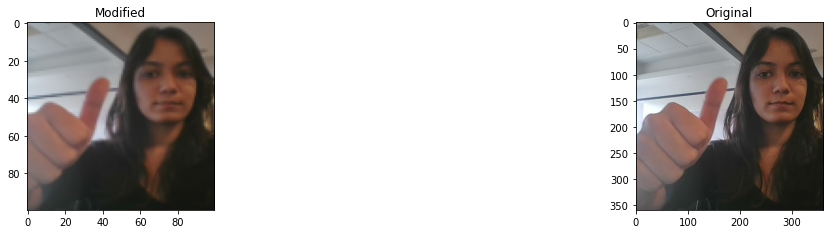

In [7]:
paths = ["/home/datasets/Project_data/train/WIN_20180907_15_53_00_Pro_Thumbs Down_new/WIN_20180907_15_53_00_Pro_00001.png",
        "/home/datasets/Project_data/train/WIN_20180907_15_56_38_Pro_Right Swipe_new/WIN_20180907_15_56_38_Pro_00013.png",
        "/home/datasets/Project_data/train/WIN_20180925_17_22_32_Pro_Right_Swipe_new/WIN_20180925_17_22_32_Pro_00009.png",
        "/home/datasets/Project_data/train/WIN_20180907_15_53_12_Pro_Thumbs Up_new/WIN_20180907_15_53_12_Pro_00011.png"]

show_resize_crop_image(paths)

In [8]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, len(img_idx), image_height, image_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, gestures)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize_crop_image(image)
                                         
                    batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size * num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            
            for batch in range(batch_size): # we iterate over the number of batches
                batch_data = np.zeros((batch_size, len(img_idx), image_height, image_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((batch_size, gestures)) # batch_labels is the one hot representation of the output
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                        #crop the images and resize them. Note that the images are of 2 different shape 
                        #and the conv3D will throw error if the inputs in a batch have different shapes
                        image = resize_crop_image(image)
                                         
                        batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image
                    
                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [9]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Experiment 1

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [11]:
optimiser = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 15, 100, 100, 8)   656       
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 100, 100, 8)   32        
_________________________________________________________________
activation (Activation)      (None, 15, 100, 100, 8)   0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 50, 50, 8)      0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 50, 50, 16)     3472      
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 50, 50, 16)     64        
_________________________________________________________________
activation_1 (Activation)    (None, 7, 50, 50, 16)     0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [12]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [13]:
model_name = 'model_init_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [14]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [15]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.7717 - categorical_accuracy: 0.2051Source path =  /home/datasets/Project_data/val ; batch size = 8

Epoch 00001: val_loss improved from inf to 1.59229, saving model to model_init_2021-06-2808_36_21.106173/model-00001-1.77166-0.20513-1.59229-0.27000.h5
83/83 [==============================] - 82s 993ms/step - loss: 1.7717 - categorical_accuracy: 0.2051 - val_loss: 1.5923 - val_categorical_accuracy: 0.2700
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.5893 - categorical_accuracy: 0.2478
Epoch 00002: val_loss improved from 1.59229 to 1.52560, saving model to model_init_2021-06-2808_36_21.106173/model-00002-1.58934-0.24785-1.52560-0.26923.h5
83/83 [==============================] - 68s 819ms/step - loss: 1.5893 - categorical_accuracy: 0.2478 - val_loss: 1.5256 - val_categorical_accuracy: 0.2692
Epoch 3/25
83/83 [====================

**Training Accuracy:** 0.45%

**Validation Accuracy:** 0.65%

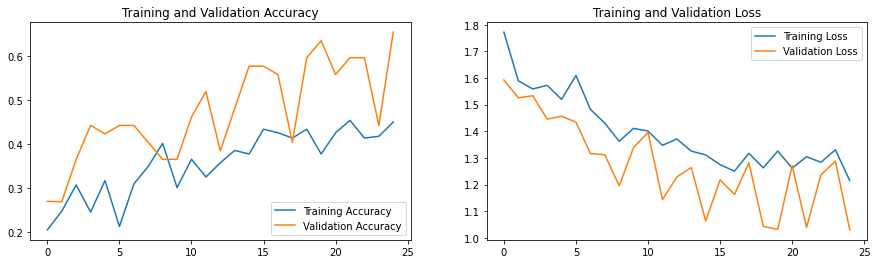

In [16]:
from IPython.display import Markdown, display

def plot_history(history):
    display(Markdown("**Training Accuracy:** " + str(round(history.history['categorical_accuracy'][num_epochs-1], 2)) + "%"))
    display(Markdown("**Validation Accuracy:** " + str(round(history.history['val_categorical_accuracy'][num_epochs-1], 2)) + "%"))
    
    #print("Training Accuracy:" + history.history['categorical_accuracy'][num_epochs-1])
    #print("Validation Accuracy:" + history.history['val_categorical_accuracy'][num_epochs-1])

    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)

From the graph we can see that the model is performing better on the validation data than on the training data. This indicates that the model is too simple and has lesser that required training parameters

### Experiment 2

Reducing the size of the image from 100 to 50

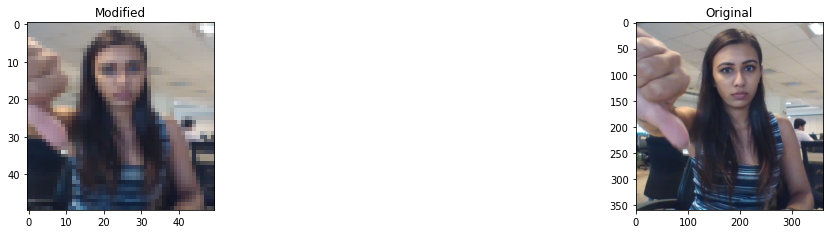

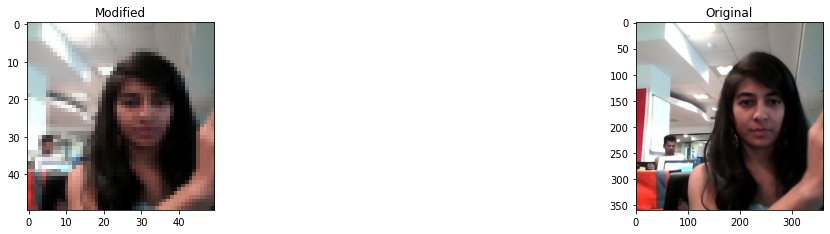

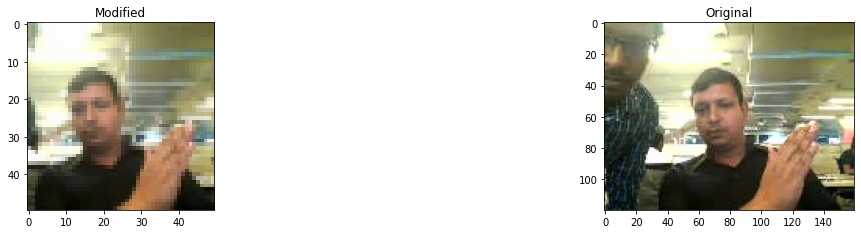

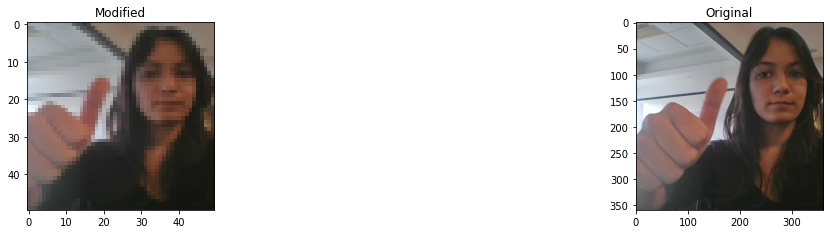

In [17]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

num_epochs=25

show_resize_crop_image(paths)

In [18]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

Compiling the model and printing the summary of the model

In [19]:
optimiser = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 15, 50, 50, 8)     656       
_________________________________________________________________
batch_normalization_3 (Batch (None, 15, 50, 50, 8)     32        
_________________________________________________________________
activation_3 (Activation)    (None, 15, 50, 50, 8)     0         
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 7, 25, 25, 8)      0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 7, 25, 25, 16)     3472      
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 25, 25, 16)     64        
_________________________________________________________________
activation_4 (Activation)    (None, 7, 25, 25, 16)    

Creating the generators

In [20]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [21]:
model_name = 'model_exp2_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [22]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Fit the model and save the model parameters

In [23]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.9441 - categorical_accuracy: 0.2112Source path =  /home/datasets/Project_data/val ; batch size = 8

Epoch 00001: val_loss improved from inf to 1.70630, saving model to model_exp2_2021-06-2808_36_21.106173/model-00001-1.94413-0.21116-1.70630-0.18000.h5
83/83 [==============================] - 76s 915ms/step - loss: 1.9441 - categorical_accuracy: 0.2112 - val_loss: 1.7063 - val_categorical_accuracy: 0.1800
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.5955 - categorical_accuracy: 0.2444
Epoch 00002: val_loss improved from 1.70630 to 1.48438, saving model to model_exp2_2021-06-2808_36_21.106173/model-00002-1.59549-0.24441-1.48438-0.36538.h5
83/83 [==============================] - 62s 752ms/step - loss: 1.5955 - categorical_accuracy: 0.2444 - val_loss: 1.4844 - val_categorical_accuracy: 0.3654
Epoch 3/25
83/83 [====================

Evaluate the performance of this model

**Training Accuracy:** 0.42%

**Validation Accuracy:** 0.58%

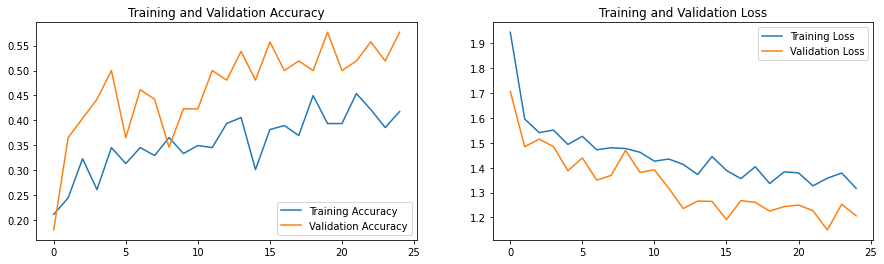

In [24]:
plot_history(history)

<b>Conclusion:</b> Scaling to smaller images work better

## Experiment 3

Reducing the size of the image from 50 to 25

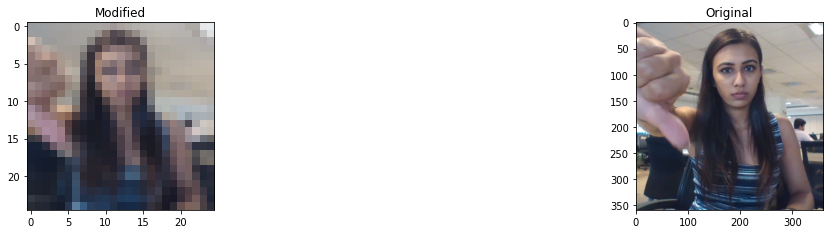

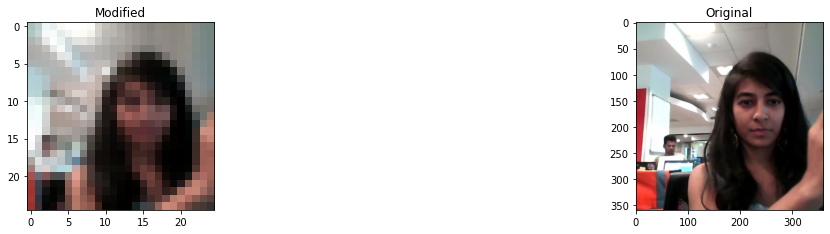

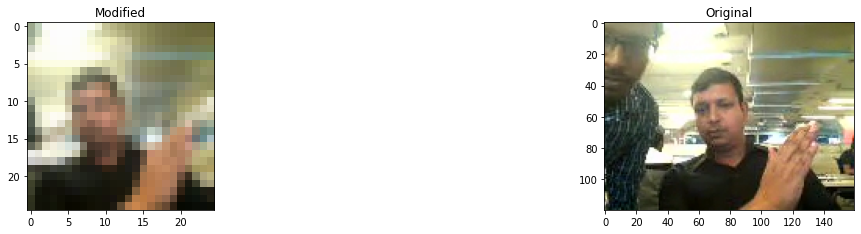

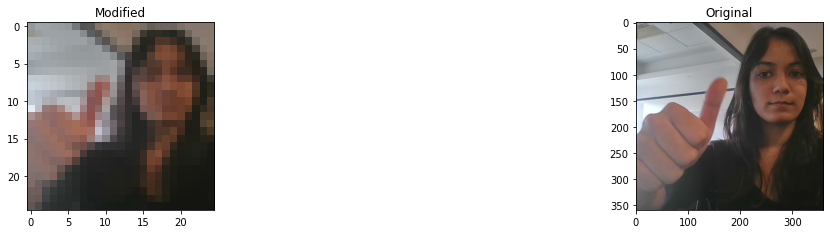

In [25]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 25
image_width = 25
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

num_epochs=25

show_resize_crop_image(paths)

In [26]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

Compiling the model and printing the summary of the model

In [27]:
optimiser = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 15, 25, 25, 8)     656       
_________________________________________________________________
batch_normalization_6 (Batch (None, 15, 25, 25, 8)     32        
_________________________________________________________________
activation_6 (Activation)    (None, 15, 25, 25, 8)     0         
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 7, 12, 12, 8)      0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 7, 12, 12, 16)     3472      
_________________________________________________________________
batch_normalization_7 (Batch (None, 7, 12, 12, 16)     64        
_________________________________________________________________
activation_7 (Activation)    (None, 7, 12, 12, 16)    

Creating the generators

In [28]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [29]:
model_name = 'model_exp3_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [30]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Fit the model and save the model parameters

In [31]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.9645 - categorical_accuracy: 0.2428Source path =  /home/datasets/Project_data/val ; batch size = 8

Epoch 00001: val_loss improved from inf to 1.55090, saving model to model_exp3_2021-06-2808_36_21.106173/model-00001-1.96445-0.24284-1.55090-0.25000.h5
83/83 [==============================] - 82s 985ms/step - loss: 1.9645 - categorical_accuracy: 0.2428 - val_loss: 1.5509 - val_categorical_accuracy: 0.2500
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.5928 - categorical_accuracy: 0.2823
Epoch 00002: val_loss improved from 1.55090 to 1.54896, saving model to model_exp3_2021-06-2808_36_21.106173/model-00002-1.59280-0.28227-1.54896-0.30769.h5
83/83 [==============================] - 68s 824ms/step - loss: 1.5928 - categorical_accuracy: 0.2823 - val_loss: 1.5490 - val_categorical_accuracy: 0.3077
Epoch 3/25
83/83 [====================

Evaluate the performance of this model

**Training Accuracy:** 0.48%

**Validation Accuracy:** 0.67%

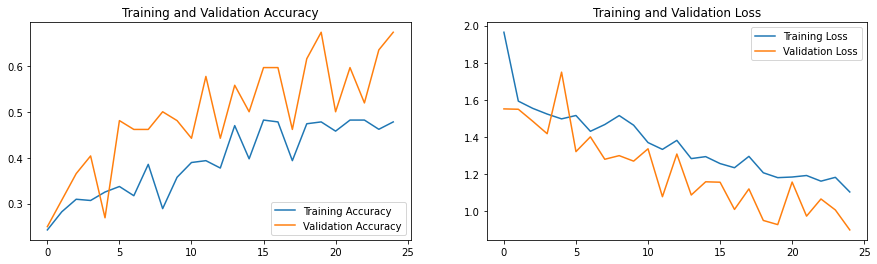

In [32]:
plot_history(history)

<b>Conclusion:</b> Scaling from 50 to 25 reduced the training and validation accuracy

### Experiment 4

Decreasing the batch size from 8 to 4

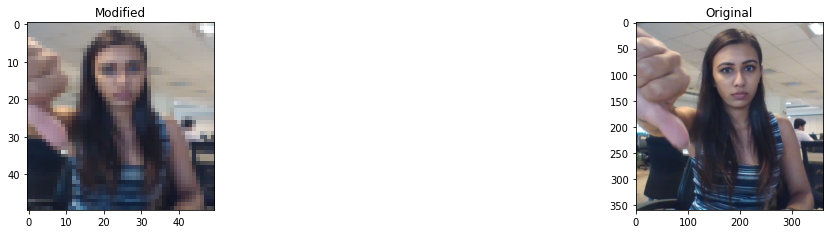

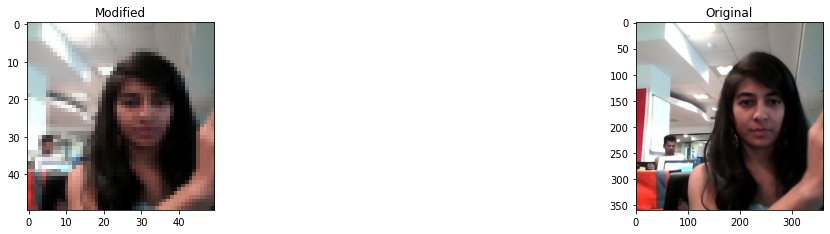

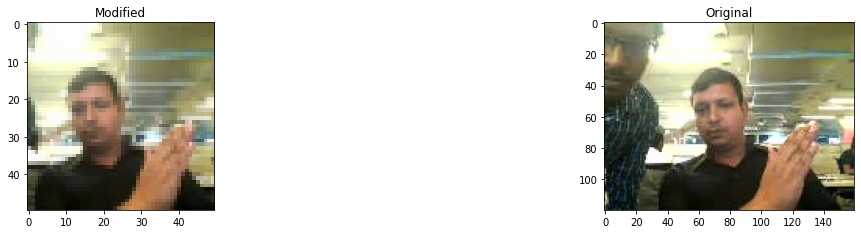

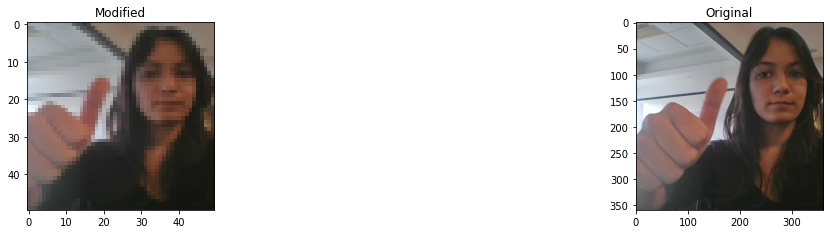

In [33]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

num_epochs=25

show_resize_crop_image(paths)

In [34]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

Compiling the model and printing the summary of the model

In [35]:
optimiser = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 15, 50, 50, 8)     656       
_________________________________________________________________
batch_normalization_9 (Batch (None, 15, 50, 50, 8)     32        
_________________________________________________________________
activation_9 (Activation)    (None, 15, 50, 50, 8)     0         
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 7, 25, 25, 8)      0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 7, 25, 25, 16)     3472      
_________________________________________________________________
batch_normalization_10 (Batc (None, 7, 25, 25, 16)     64        
_________________________________________________________________
activation_10 (Activation)   (None, 7, 25, 25, 16)    

Creating the generators

In [36]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [37]:
model_name = 'model_exp4_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [38]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Fit the model and save the model parameters

In [39]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.7629 - categorical_accuracy: 0.2217Source path =  /home/datasets/Project_data/val ; batch size = 4

Epoch 00001: val_loss improved from inf to 1.58244, saving model to model_exp4_2021-06-2808_36_21.106173/model-00001-1.76295-0.22172-1.58244-0.26000.h5
166/166 [==============================] - 80s 480ms/step - loss: 1.7629 - categorical_accuracy: 0.2217 - val_loss: 1.5824 - val_categorical_accuracy: 0.2600
Epoch 2/25
166/166 [==============================] - ETA: 0s - loss: 1.6197 - categorical_accuracy: 0.2249
Epoch 00002: val_loss did not improve from 1.58244
166/166 [==============================] - 63s 382ms/step - loss: 1.6197 - categorical_accuracy: 0.2249 - val_loss: 1.6016 - val_categorical_accuracy: 0.2000
Epoch 3/25
166/166 [==============================] - ETA: 0s - loss: 1.6038 - categorical_accuracy: 0.2349
Epoch 00003: val_loss did n

Evaluate the performance of this model

**Training Accuracy:** 0.4%

**Validation Accuracy:** 0.56%

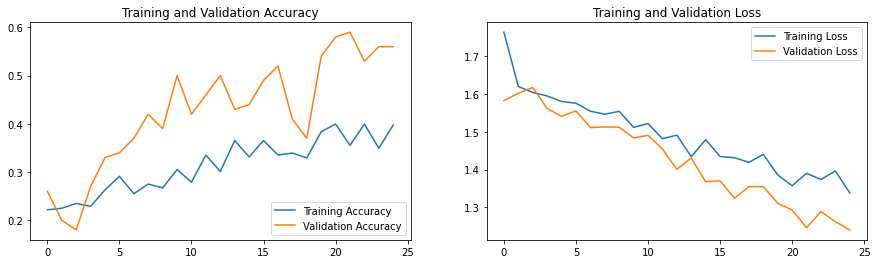

In [40]:
plot_history(history)

<b>Conclusion:</b> Reducing the batch size has reduced overfitting

### Experiment 5

Changing the optmizer from `SGD` to `Adam`

In [41]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4
num_epochs=25

img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

In [42]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 15, 50, 50, 8)     656       
_________________________________________________________________
batch_normalization_12 (Batc (None, 15, 50, 50, 8)     32        
_________________________________________________________________
activation_12 (Activation)   (None, 15, 50, 50, 8)     0         
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 7, 25, 25, 8)      0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 7, 25, 25, 16)     3472      
_________________________________________________________________
batch_normalization_13 (Batc (None, 7, 25, 25, 16)     64        
_________________________________________________________________
activation_13 (Activation)   (None, 7, 25, 25, 16)    

In [43]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [44]:
model_name = 'model_exp5_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [45]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [46]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.8307 - categorical_accuracy: 0.2112Source path =  /home/datasets/Project_data/val ; batch size = 4

Epoch 00001: val_loss improved from inf to 1.58582, saving model to model_exp5_2021-06-2808_36_21.106173/model-00001-1.83070-0.21116-1.58582-0.31000.h5
166/166 [==============================] - 79s 477ms/step - loss: 1.8307 - categorical_accuracy: 0.2112 - val_loss: 1.5858 - val_categorical_accuracy: 0.3100
Epoch 2/25
166/166 [==============================] - ETA: 0s - loss: 1.6207 - categorical_accuracy: 0.2430
Epoch 00002: val_loss did not improve from 1.58582
166/166 [==============================] - 63s 380ms/step - loss: 1.6207 - categorical_accuracy: 0.2430 - val_loss: 1.5871 - val_categorical_accuracy: 0.3600
Epoch 3/25
166/166 [==============================] - ETA: 0s - loss: 1.5866 - categorical_accuracy: 0.2731
Epoch 00003: val_loss impro

**Training Accuracy:** 0.54%

**Validation Accuracy:** 0.71%

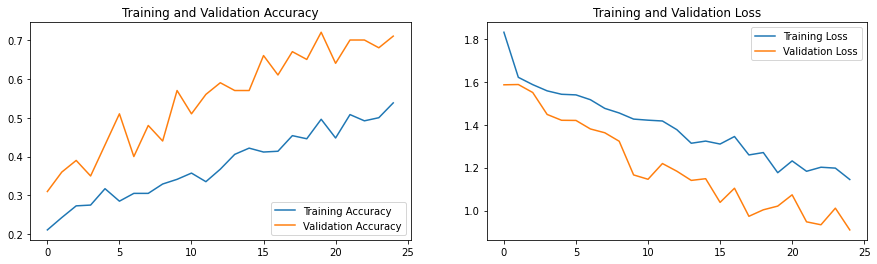

In [47]:
plot_history(history)

<b>Conclusion:</b> `Adam` has reduced overfitting. However since the accuracy has been constantly improving we might need to increase the number of epochs in a later experiment

### Experiment 6

Reducing the number of frames from 15 to 10

In [48]:
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4
num_epochs=25

img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

In [49]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_15 (Conv3D)           (None, 10, 50, 50, 8)     656       
_________________________________________________________________
batch_normalization_15 (Batc (None, 10, 50, 50, 8)     32        
_________________________________________________________________
activation_15 (Activation)   (None, 10, 50, 50, 8)     0         
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 5, 25, 25, 8)      0         
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 5, 25, 25, 16)     3472      
_________________________________________________________________
batch_normalization_16 (Batc (None, 5, 25, 25, 16)     64        
_________________________________________________________________
activation_16 (Activation)   (None, 5, 25, 25, 16)    

In [50]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [51]:
model_name = 'model_exp6_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [52]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [53]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.8471 - categorical_accuracy: 0.2278Source path =  /home/datasets/Project_data/val ; batch size = 4

Epoch 00001: val_loss improved from inf to 1.57750, saving model to model_exp6_2021-06-2808_36_21.106173/model-00001-1.84707-0.22775-1.57750-0.24000.h5
166/166 [==============================] - 55s 329ms/step - loss: 1.8471 - categorical_accuracy: 0.2278 - val_loss: 1.5775 - val_categorical_accuracy: 0.2400
Epoch 2/25
166/166 [==============================] - ETA: 0s - loss: 1.6260 - categorical_accuracy: 0.2068
Epoch 00002: val_loss did not improve from 1.57750
166/166 [==============================] - 44s 263ms/step - loss: 1.6260 - categorical_accuracy: 0.2068 - val_loss: 1.5851 - val_categorical_accuracy: 0.3100
Epoch 3/25
166/166 [==============================] - ETA: 0s - loss: 1.5886 - categorical_accuracy: 0.2731
Epoch 00003: val_loss impro

**Training Accuracy:** 0.42%

**Validation Accuracy:** 0.61%

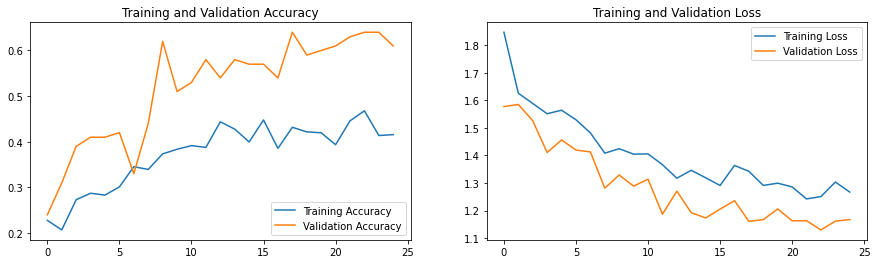

In [54]:
plot_history(history)

<b>Conclusion:</b> The training and validation accuracy has increased after reducing the number of frames from 15 to 10

### Experiment 7

Reducing the dropout rate from 0.5 to 0.25

In [55]:
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

num_epochs=25

In [56]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_18 (Conv3D)           (None, 10, 50, 50, 8)     656       
_________________________________________________________________
batch_normalization_18 (Batc (None, 10, 50, 50, 8)     32        
_________________________________________________________________
activation_18 (Activation)   (None, 10, 50, 50, 8)     0         
_________________________________________________________________
max_pooling3d_18 (MaxPooling (None, 5, 25, 25, 8)      0         
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 5, 25, 25, 16)     3472      
_________________________________________________________________
batch_normalization_19 (Batc (None, 5, 25, 25, 16)     64        
_________________________________________________________________
activation_19 (Activation)   (None, 5, 25, 25, 16)    

In [57]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [58]:
model_name = 'model_exp7_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [59]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [60]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.7528 - categorical_accuracy: 0.2172Source path =  /home/datasets/Project_data/val ; batch size = 4

Epoch 00001: val_loss improved from inf to 1.53606, saving model to model_exp7_2021-06-2808_36_21.106173/model-00001-1.75284-0.21719-1.53606-0.28000.h5
166/166 [==============================] - 55s 329ms/step - loss: 1.7528 - categorical_accuracy: 0.2172 - val_loss: 1.5361 - val_categorical_accuracy: 0.2800
Epoch 2/25
166/166 [==============================] - ETA: 0s - loss: 1.5380 - categorical_accuracy: 0.3193
Epoch 00002: val_loss improved from 1.53606 to 1.43371, saving model to model_exp7_2021-06-2808_36_21.106173/model-00002-1.53800-0.31928-1.43371-0.42000.h5
166/166 [==============================] - 45s 270ms/step - loss: 1.5380 - categorical_accuracy: 0.3193 - val_loss: 1.4337 - val_categorical_accuracy: 0.4200
Epoch 3/25
166/166 [==========

**Training Accuracy:** 0.9%

**Validation Accuracy:** 0.8%

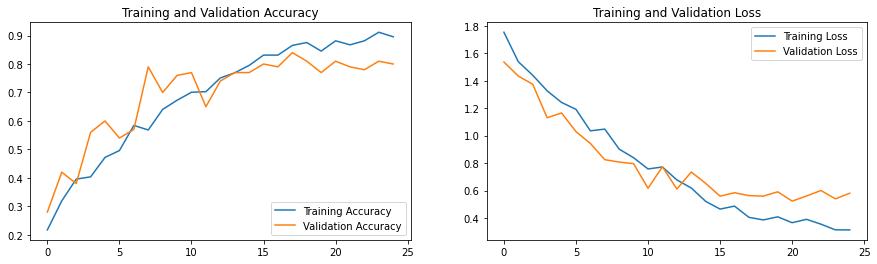

In [61]:
plot_history(history)

<b>Conclusion:</b> A drop out rate of 0.25 gives up a better training and validation accuracy

### Experiment 8

Increasing the number of epochs from 25 to 35

In [62]:
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

num_epochs=35

In [63]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_21 (Conv3D)           (None, 10, 50, 50, 8)     656       
_________________________________________________________________
batch_normalization_21 (Batc (None, 10, 50, 50, 8)     32        
_________________________________________________________________
activation_21 (Activation)   (None, 10, 50, 50, 8)     0         
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 5, 25, 25, 8)      0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 5, 25, 25, 16)     3472      
_________________________________________________________________
batch_normalization_22 (Batc (None, 5, 25, 25, 16)     64        
_________________________________________________________________
activation_22 (Activation)   (None, 5, 25, 25, 16)    

In [64]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [65]:
model_name = 'model_exp8_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [66]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [67]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 4
Epoch 1/35
166/166 [==============================] - ETA: 0s - loss: 1.7059 - categorical_accuracy: 0.2021Source path =  /home/datasets/Project_data/val ; batch size = 4

Epoch 00001: val_loss improved from inf to 1.54653, saving model to model_exp8_2021-06-2808_36_21.106173/model-00001-1.70590-0.20211-1.54653-0.32000.h5
166/166 [==============================] - 55s 331ms/step - loss: 1.7059 - categorical_accuracy: 0.2021 - val_loss: 1.5465 - val_categorical_accuracy: 0.3200
Epoch 2/35
166/166 [==============================] - ETA: 0s - loss: 1.5649 - categorical_accuracy: 0.2731
Epoch 00002: val_loss improved from 1.54653 to 1.30555, saving model to model_exp8_2021-06-2808_36_21.106173/model-00002-1.56489-0.27309-1.30555-0.54000.h5
166/166 [==============================] - 45s 273ms/step - loss: 1.5649 - categorical_accuracy: 0.2731 - val_loss: 1.3056 - val_categorical_accuracy: 0.5400
Epoch 3/35
166/166 [==========

**Training Accuracy:** 0.88%

**Validation Accuracy:** 0.84%

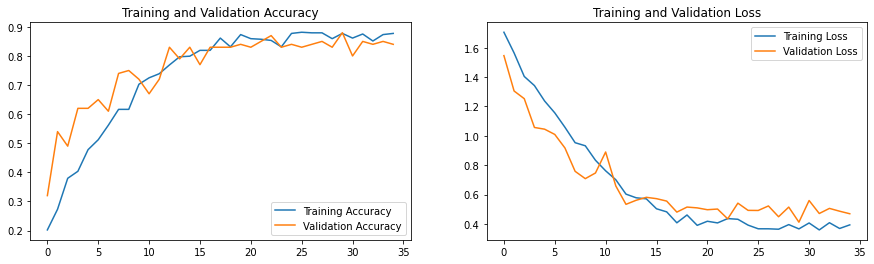

In [68]:
plot_history(history)

<b>Conclusion:</b> After 35 epochs the training and validation accuracy changes to 88% and 84% respectively